In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from datetime import date
import calendar

In [3]:
# importe les données dans un dataframe
birth_df = pd.read_csv("birth.csv", sep=",")

In [195]:
print("Nombre total de lignes :", birth_df.index.size)
print("Nombre de non nul par colonne :",birth_df.count())  # count compte seulmt les valeurs renseignées de chaque colonne (!= de .size, qui compte tout)
# En comptant les éléments par colonne on s'aperçoit que seuls certains jours ne sont pas renseignés

birth_df.head(3)

Nombre total de lignes : 14265
Nombre de non nul par colonne : gender      14265
births      14265
date        14265
day_week    13819
dtype: int64


,gender,births,date,day_week
0,F,4046.0,1969-01-01,Wednesday
1,M,4440.0,1969-01-01,Wednesday
2,F,4454.0,1969-01-02,Thursday


In [5]:
print("Nbe de lignes, avant nettoyage :" , birth_df.index.size)

# élimination des lignes dont l'année, le mois ou le jour n'est pas renseigné
birth_df.dropna(subset = ['year','month','day'], inplace=True)

# on garde seulement les lignes dont les années sont entre 1900 et 2019
#cond_y = pd.Series((birth_df.year < 2019)&(birth_df.year > 1900))

# on garde seulement les lignes dont les mois sont compris entre 1 et 12
#cond_m = pd.Series([birth_df.month[i] in range (1,13) for i in range(len(birth_df.month))])

# on garde seulement les lignes dont les jours sont compris entre 1 et 31
cond_d = pd.Series([birth_df.day.values[i] in range (1,32) for i in range(len(birth_df.day))], \
                   index = birth_df.day.index)

birth_df = birth_df.where(cond_d).dropna()

# nbe de lignes après triage
print("Nbe de lignes, après nettoyage :", birth_df.index.size)

Nbe de lignes, avant nettoyage : 15547
Nbe de lignes, après nettoyage : 14717


In [6]:
# Crée une dataframe contenant les données pour former les dates

date_df = pd.DataFrame({'year':birth_df.year.values.astype(int),\
                        'month':birth_df.month.values.astype(int),\
                        'day':birth_df.day.values.astype(int)})
date_ser = pd.to_datetime(date_df,errors='coerce') # type "Series"

birth_df["date"] = date_ser
birth_df.drop(columns = ["year", "month", "day"], inplace=True)

In [7]:
# élimination des lignes dont l'année, le mois et le jour forment une date qui n'existe pas
# notamment les 29 janvier d'années non bissextile
birth_df = birth_df.dropna(subset = ['date'])

# nbe de lignes après triage
print("Nbe de lignes, après nettoyage :", birth_df.index.size)

birth_df.head(5)

Nbe de lignes, après nettoyage : 14265


,gender,births,date
0,F,4046.0,1969-01-01
1,M,4440.0,1969-01-01
2,F,4454.0,1969-01-02
3,M,4548.0,1969-01-02
4,F,4548.0,1969-01-03


In [104]:
# ajout d'une nouvelle colonne indiquant le nom du jour de naissance

tab = [calendar.day_name[birth_df.iloc[i].date.weekday()] for i in range(birth_df.index.size)]

day_week_ser = pd.Series(tab)
birth_df["day_week"] = day_week_ser

In [106]:
birth_df.head(10)

,gender,births,date,day_week
0,F,4046.0,1969-01-01,Wednesday
1,M,4440.0,1969-01-01,Wednesday
2,F,4454.0,1969-01-02,Thursday
3,M,4548.0,1969-01-02,Thursday
4,F,4548.0,1969-01-03,Friday
5,M,4994.0,1969-01-03,Friday
6,F,4440.0,1969-01-04,Saturday
7,M,4520.0,1969-01-04,Saturday
8,F,4192.0,1969-01-05,Sunday
9,M,4198.0,1969-01-05,Sunday


In [122]:
birth_pt = birth_df.pivot_table('births', index ='gender', columns = 'day_week', aggfunc = "sum")

In [123]:
birth_pt

day_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
gender,,,,,,,
F,4549799.0,4580154.0,4590412.0,4563892.0,4589039.0,4554823.0,4614031.0
M,4814687.0,4775277.0,4850106.0,4827271.0,4851082.0,4790185.0,4832452.0


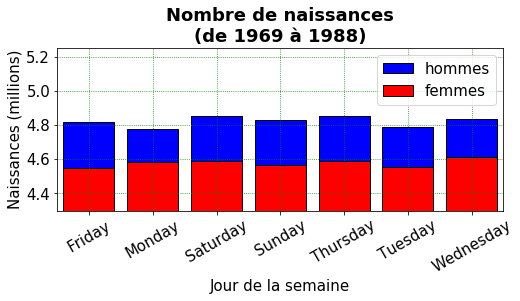

In [221]:
l1 = birth_pt.loc['M'].values
l2 = birth_pt.loc['F'].values
ind = birth_pt.loc['M'].index

y_min = np.min(l1)*0.9/1e6
y_max = np.min(l1)*1.1/1e6

fig = plt.figure(figsize=(8,3))

plt.bar(range(len(l1)),l1/1000000,edgecolor='k', color='b', label='hommes')
plt.bar(range(len(l2)),l2/1000000,edgecolor='k', color='r', label='femmes')

plt.title("Nombre de naissances\n(de 1969 à 1988)",fontweight="bold")
plt.xlabel("Jour de la semaine")
plt.ylabel("Naissances (millions)")
plt.axis([-0.5, 6.5, y_min, y_max])
plt.rcParams.update({'font.size': 15})
plt.grid(color='g', linestyle='dotted')
plt.xticks(range(7), ind, rotation=30)
plt.legend(loc='upper right')

plt.show()

